In [1]:
# Install deepflash2 and dependencies
import sys
# sys.path.append("../input/zarrkaggleinstall")
# sys.path.append("../input/segmentation-models-pytorch-install")
# !pip install -q --no-deps ../input/deepflash2-lfs
import cv2, torch, zarr, tifffile, pandas as pd, gc
from fastai.vision.all import *
from deepflash2.all import *
import segmentation_models_pytorch as smp
import albumentations as alb

In [2]:
# !pip install zarr
# !pip install fastai
# !pip install --no-deps deepflash2-lfs/
# !pip install segmentation_models_pytorch
# !pip install albumentations

In [3]:
@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [4]:
class CONFIG():
    
    # data paths
    data_path = Path('/storage/data/kaggle')
    data_path_zarr = Path('working/train_scaleNone')
    mask_preproc_dir = 'working/masks_scaleNone'
    
    # deepflash2 dataset
    scale = 15.6575 #15.6575 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (160,160) #(160, 160)
    padding = (0,0) # Border overlap for prediction
    n_jobs = 1
    sample_mult = 100 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.7720342,0.74582646,0.76392896]), np.array([0.24745085,0.26182273,0.25782376])

    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)
    

    # pytorch model (segmentation_models_pytorch)
    encoder_name = "efficientnet-b4"
    encoder_weights = 'imagenet'
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 16 #16
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1)
    metrics = [Iou(), Dice_f1()]
    optimizer = ranger
    max_learning_rate = 1e-3
    epochs = 12 #12
    
cfg = CONFIG()

In [5]:
# Inspired by https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter
# deepflash2 augmentations are only affine transformations
tfms = alb.OneOf([
    alb.HueSaturationValue(10,15,10),
    alb.CLAHE(clip_limit=2),
    alb.RandomBrightnessContrast(),            
    ], p=0.3)

In [6]:
df_train = pd.read_csv(cfg.data_path/'train.csv')
df_external = pd.read_csv('external.csv')
df = pd.concat([df_external,df_train])

In [7]:
# df_train = pd.read_csv(cfg.data_path/'train.csv')
# df_external = pd.read_csv('external.csv')
# df_info = pd.read_csv(cfg.data_path/'HuBMAP-20-dataset_information.csv')

df2 = df.query("organ == 'prostate'")
files = [cfg.data_path_zarr/f'{idx}' for idx in df2.id]

# files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')]
label_fn = lambda o: o

In [8]:
files[:20]

[Path('working/train_scaleNone/GTEX-11P82-1126'),
 Path('working/train_scaleNone/10044'),
 Path('working/train_scaleNone/10274'),
 Path('working/train_scaleNone/10666'),
 Path('working/train_scaleNone/10912'),
 Path('working/train_scaleNone/10971'),
 Path('working/train_scaleNone/1184'),
 Path('working/train_scaleNone/12233'),
 Path('working/train_scaleNone/12244'),
 Path('working/train_scaleNone/1229'),
 Path('working/train_scaleNone/13483'),
 Path('working/train_scaleNone/13942'),
 Path('working/train_scaleNone/14396'),
 Path('working/train_scaleNone/14407'),
 Path('working/train_scaleNone/1500'),
 Path('working/train_scaleNone/15706'),
 Path('working/train_scaleNone/15732'),
 Path('working/train_scaleNone/16149'),
 Path('working/train_scaleNone/16609'),
 Path('working/train_scaleNone/16659')]

In [9]:
len(files)

94

In [10]:
# Model
model = smp.Unet(encoder_name=cfg.encoder_name, 
                 encoder_weights=cfg.encoder_weights, 
                 in_channels=cfg.in_channels, 
                 classes=cfg.classes)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

In [11]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

train_ds = RandomTileDataset(files, label_fn=label_fn, **ds_kwargs)
valid_ds = TileDataset(files, label_fn=label_fn, **ds_kwargs, is_zarr=True)

Using preprocessed masks from working/masks_scaleNone
Using preprocessed masks from working/masks_scaleNone


In [12]:
dls = DataLoaders.from_dsets(train_ds,valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))


In [13]:
# Dataloader and learner
# dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
if torch.cuda.is_available(): dls.cuda(), model.cuda()
cbs = [SaveModelCallback(monitor='iou'), ElasticDeformCallback]
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=cfg.loss_func, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()
  

In [14]:
x, y =dls.one_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


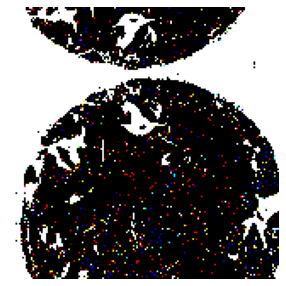

In [15]:
(x[15]*255).show();

In [16]:
# learn.fine_tune(5)
# learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,iou,dice_f1,time
0,0.141572,0.131062,0.702684,0.825384,01:28
1,0.084321,0.123907,0.738795,0.849778,01:23
2,0.073580,0.090154,0.782669,0.878087,01:25
3,0.065406,0.090125,0.792403,0.884180,01:26
4,0.056718,0.084348,0.806647,0.892977,01:22
5,0.053500,0.078712,0.822811,0.902793,01:25
6,0.050636,0.068775,0.837010,0.911274,01:26
7,0.048625,0.068830,0.840658,0.913432,01:25
8,0.049562,0.056373,0.860234,0.924866,01:22
9,0.051613,0.055376,0.861595,0.925653,01:26


Better model found at epoch 0 with iou value: 0.7026835702309774.
Better model found at epoch 1 with iou value: 0.7387952573054669.
Better model found at epoch 2 with iou value: 0.782669472224425.
Better model found at epoch 3 with iou value: 0.7924034937979931.
Better model found at epoch 4 with iou value: 0.8066472359112811.
Better model found at epoch 5 with iou value: 0.8228107964269172.
Better model found at epoch 6 with iou value: 0.8370096888196435.
Better model found at epoch 7 with iou value: 0.8406578846371747.
Better model found at epoch 8 with iou value: 0.8602340848843323.
Better model found at epoch 9 with iou value: 0.8615953982584281.
Better model found at epoch 10 with iou value: 0.8637558237605233.
Better model found at epoch 11 with iou value: 0.8638570150185952.


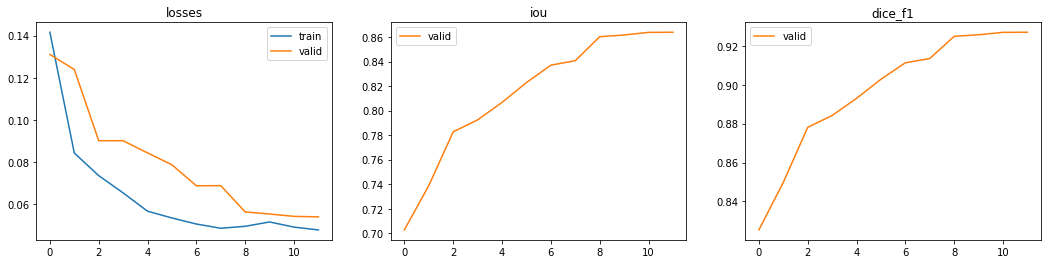

In [17]:
# b4
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

In [ ]:
# Fit
# learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
# learn.recorder.plot_metrics()

In [20]:
# Save Model
state = {'model': learn.model.state_dict(), 'stats':cfg.stats}
torch.save(state, 'b4_models/prostate.pth', pickle_protocol=2, _use_new_zipfile_serialization=False)